# High-Accuracy Cerebral Stroke Detection and Classification of Ischemic vs. Hemorrhagic Types using an End-to-End ConvNeXt Vision Pipeline

In [1]:
import random
import numpy as np
import torch
import warnings

warnings.filterwarnings('ignore')

# Set a fixed random seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Enforce deterministic behavior in CUDA operations
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print("Random seed set to:", seed)
print("Deterministic mode enabled for PyTorch.")

Random seed set to: 42
Deterministic mode enabled for PyTorch.


Number of absent images: 4551
Number of ischemic stroke images: 1130
Number of hemorrhagic stroke images: 1093

Average dimensions (Height x Width):
Absent: 515.4 x 512.5
Ischemic: 514.1 x 512.0
Hemorrhagic: 513.9 x 512.3


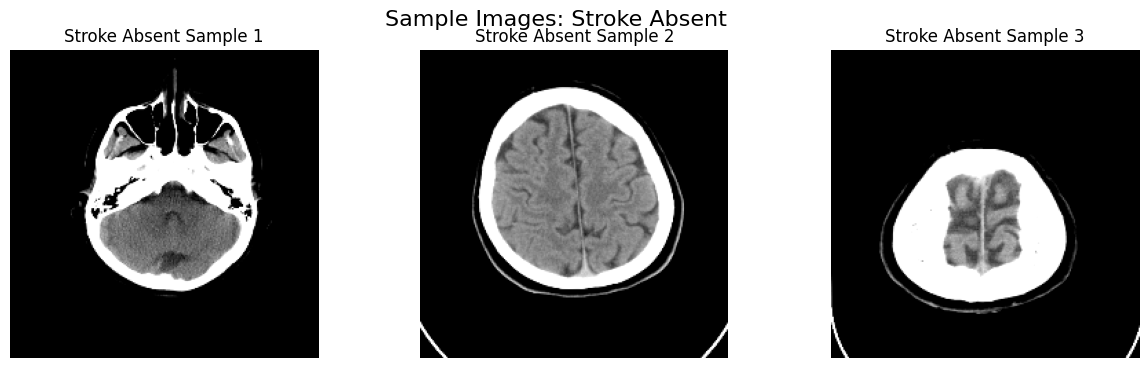

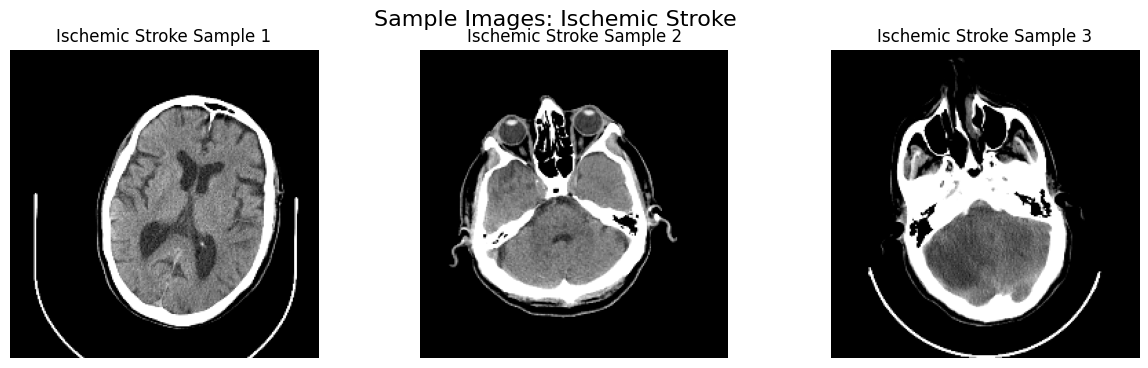

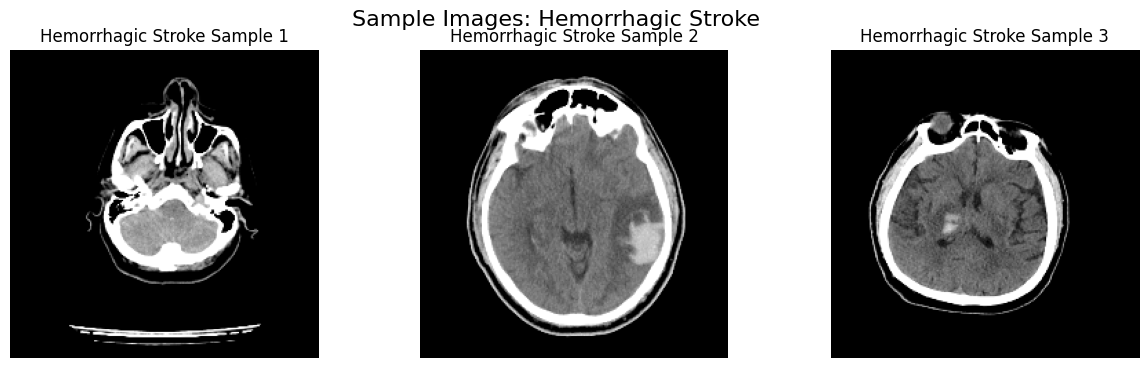

In [2]:
import os
from glob import glob
import cv2
import matplotlib.pyplot as plt

# Define base directories for the dataset
BASE_DIR = '/kaggle/input/inme-veri-seti-stroke-dataset/İNME VERİ SETİ'
stroke_absent_dir = os.path.join(BASE_DIR, "İnme Yok")
stroke_iskemi_dir = os.path.join(BASE_DIR, "İskemi", "PNG")
stroke_kanama_dir = os.path.join(BASE_DIR, "Kanama", "PNG")

# Retrieve image file paths for each class
absent_paths = glob(os.path.join(stroke_absent_dir, "*"))
iskemi_paths = glob(os.path.join(stroke_iskemi_dir, "*"))
kanama_paths = glob(os.path.join(stroke_kanama_dir, "*"))

print("Number of absent images:", len(absent_paths))
print("Number of ischemic stroke images:", len(iskemi_paths))
print("Number of hemorrhagic stroke images:", len(kanama_paths))

# Function to compute image dimensions statistics
def image_statistics(image_paths):
    heights, widths = [], []
    for path in image_paths:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            h, w = img.shape
            heights.append(h)
            widths.append(w)
    return np.mean(heights), np.mean(widths), np.min(heights), np.max(heights), np.min(widths), np.max(widths)

absent_stats = image_statistics(absent_paths)
iskemi_stats = image_statistics(iskemi_paths)
kanama_stats = image_statistics(kanama_paths)

print("\nAverage dimensions (Height x Width):")
print("Absent: {:.1f} x {:.1f}".format(absent_stats[0], absent_stats[1]))
print("Ischemic: {:.1f} x {:.1f}".format(iskemi_stats[0], iskemi_stats[1]))
print("Hemorrhagic: {:.1f} x {:.1f}".format(kanama_stats[0], kanama_stats[1]))

# Visualize sample images from each class
def plot_samples(image_paths, title, n=3):
    plt.figure(figsize=(15, 4))
    for i, img_path in enumerate(image_paths[:n]):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (224, 224))
        plt.subplot(1, n, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f"{title} Sample {i+1}", fontsize=12)
        plt.axis('off')
    plt.suptitle(f"Sample Images: {title}", fontsize=16)
    plt.show()

plot_samples(absent_paths, "Stroke Absent")
plot_samples(iskemi_paths, "Ischemic Stroke")
plot_samples(kanama_paths, "Hemorrhagic Stroke")

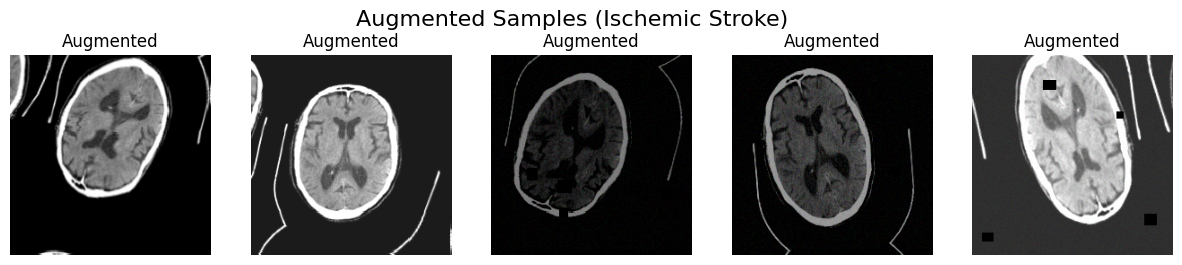

In [3]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=20, p=0.7),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=20, p=0.7),
    A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5),
    A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
    A.OpticalDistortion(distort_limit=0.2, shift_limit=0.2, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.7),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.5),
    A.CoarseDropout(max_holes=4, max_height=16, max_width=16, min_holes=1, min_height=8, min_width=8, fill_value=0, p=0.5),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2(),
])

# Visualize the effect of augmentations on a sample image
sample_img = cv2.imread(iskemi_paths[0], cv2.IMREAD_GRAYSCALE)
sample_img = cv2.resize(sample_img, (224, 224))
sample_img_rgb = cv2.cvtColor(sample_img, cv2.COLOR_GRAY2RGB)
augmented_imgs = [train_transform(image=sample_img_rgb)['image'].permute(1,2,0).numpy() for _ in range(5)]

plt.figure(figsize=(15, 3))
for i, img in enumerate(augmented_imgs):
    plt.subplot(1, 5, i+1)
    img_vis = (img * 0.5 + 0.5)  # Re-scale to [0,1] for display
    plt.imshow(img_vis)
    plt.title("Augmented", fontsize=12)
    plt.axis('off')
plt.suptitle("Augmented Samples (Ischemic Stroke)", fontsize=16)
plt.show()

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Create detailed labels for multi-class classification
# 0: Absent, 1: Ischemic, 2: Hemorrhagic
image_paths = absent_paths + iskemi_paths + kanama_paths
labels = [0] * len(absent_paths) + [1] * len(iskemi_paths) + [2] * len(kanama_paths)

class StrokeDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            raise ValueError(f"Error loading image: {img_path}")
        # No need to resize here as the augmentation pipeline will do it
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        else:
            # Basic transformation if none is provided (e.g., for raw visualization)
            image = cv2.resize(image, (224, 224))
            image = image.astype(np.float32) / 255.0
            image = np.transpose(image, (2, 0, 1))
            image = torch.tensor(image, dtype=torch.float)
        # Use LongTensor for labels in CrossEntropyLoss
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return image, label

# Stratified splitting of data to maintain class distribution
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    image_paths, labels, test_size=0.3, random_state=seed, stratify=labels
)
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.33, random_state=seed, stratify=temp_labels
)

print("Training samples:", len(train_paths))
print("Validation samples:", len(val_paths))
print("Test samples:", len(test_paths))

# Calculate class weights to handle imbalance
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
print(f"Calculated Class Weights: {class_weights}")


batch_size = 16
train_dataset = StrokeDataset(train_paths, train_labels, transform=train_transform)
val_dataset = StrokeDataset(val_paths, val_labels, transform=val_transform)
test_dataset = StrokeDataset(test_paths, test_labels, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

Training samples: 4741
Validation samples: 1362
Test samples: 671
Calculated Class Weights: tensor([0.4962, 1.9979, 2.0658], device='cuda:0')


In [5]:
import timm
import torch.nn as nn

torch.cuda.empty_cache()
print("Using device:", device)

model = timm.create_model('convnext_base', pretrained=True)
# Update the classifier for 3 classes
model.reset_classifier(num_classes=3)
model = model.to(device)
# print(model) # Optional: uncomment to see model architecture

Using device: cuda


model.safetensors:   0%|          | 0.00/354M [00:00<?, ?B/s]

In [6]:
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Use CrossEntropyLoss for multi-class and pass in the calculated class weights
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True)

scaler = torch.cuda.amp.GradScaler()

train_losses, val_losses, val_f1s = [], [], []
num_epochs = 50 # Note: With the new setup, you might need to adjust this
best_val_f1 = 0.0

def train_one_epoch(model, loader, criterion, optimizer, device, scaler):
    model.train()
    running_loss = 0.0
    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device) # No unsqueeze needed for CrossEntropyLoss
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item() * images.size(0)
    return running_loss / len(loader.dataset)

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            # Get predictions using softmax and argmax for multi-class
            preds = torch.argmax(torch.softmax(outputs, dim=1), dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
            
    avg_loss = running_loss / len(loader.dataset)
    # Use 'macro' average for metrics to treat all classes equally
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    return avg_loss, accuracy, precision, recall, f1, all_preds, all_labels

print("Starting training with multi-class weighted loss...")

for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device, scaler)
    val_loss, val_acc, val_prec, val_rec, val_f1, _, _ = evaluate(model, val_loader, criterion, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_f1s.append(val_f1)
    
    scheduler.step(val_f1)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
          f"Val Acc: {val_acc:.4f} | Val F1 (Macro): {val_f1:.4f}")
    
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), "best_model_multiclass.pth")
        print(f" --> Best model saved! Val F1: {best_val_f1:.4f}")

print("\nTraining finished.")
print(f"Best Validation F1 Score (Macro): {best_val_f1:.4f}")

# Load best model for final evaluation
model.load_state_dict(torch.load("best_model_multiclass.pth"))

# Evaluate on test set (FIXED: using metric variables)
test_loss, test_acc, test_prec, test_rec, test_f1, test_preds, test_labels_arr = evaluate(model, test_loader, criterion, device)

print(f"\n--- Test Set Evaluation ---")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision (Macro): {test_prec:.4f}")
print(f"Test Recall (Macro): {test_rec:.4f}")
print(f"Test F1 Score (Macro): {test_f1:.4f}")

Starting training with multi-class weighted loss...
Epoch [1/50] | Train Loss: 0.6774 | Val Loss: 0.3635 | Val Acc: 0.8957 | Val F1 (Macro): 0.8597
 --> Best model saved! Val F1: 0.8597
Epoch [2/50] | Train Loss: 0.3923 | Val Loss: 0.5729 | Val Acc: 0.8774 | Val F1 (Macro): 0.8056
Epoch [3/50] | Train Loss: 0.3091 | Val Loss: 0.2592 | Val Acc: 0.9295 | Val F1 (Macro): 0.9011
 --> Best model saved! Val F1: 0.9011
Epoch [4/50] | Train Loss: 0.2670 | Val Loss: 0.2389 | Val Acc: 0.9347 | Val F1 (Macro): 0.9115
 --> Best model saved! Val F1: 0.9115
Epoch [5/50] | Train Loss: 0.2171 | Val Loss: 0.3037 | Val Acc: 0.9347 | Val F1 (Macro): 0.9070
Epoch [6/50] | Train Loss: 0.1846 | Val Loss: 0.2673 | Val Acc: 0.9413 | Val F1 (Macro): 0.9155
 --> Best model saved! Val F1: 0.9155
Epoch [7/50] | Train Loss: 0.1607 | Val Loss: 0.2108 | Val Acc: 0.9295 | Val F1 (Macro): 0.9062
Epoch [8/50] | Train Loss: 0.1704 | Val Loss: 0.2835 | Val Acc: 0.9369 | Val F1 (Macro): 0.9107
Epoch [9/50] | Train Loss: 0

# Confusion Matrix on Test Set

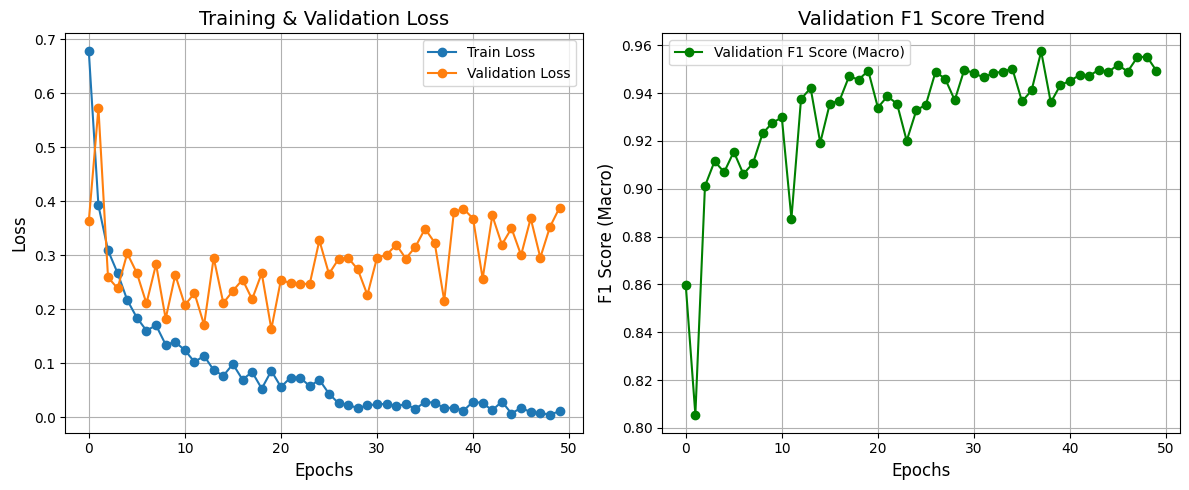

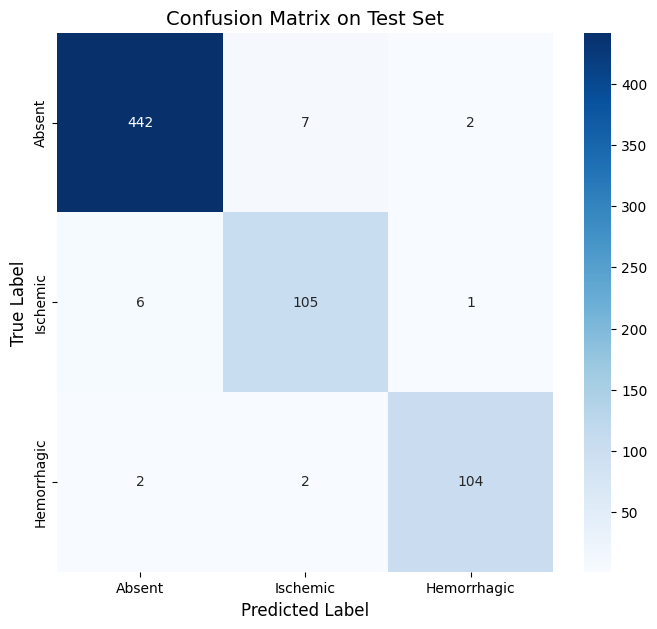

In [7]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss", marker='o')
plt.plot(val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Training & Validation Loss", fontsize=14)
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(val_f1s, label="Validation F1 Score (Macro)", color="green", marker='o')
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("F1 Score (Macro)", fontsize=12)
plt.title("Validation F1 Score Trend", fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Confusion Matrix
cm = confusion_matrix(test_labels_arr, test_preds)
plt.figure(figsize=(8, 7))
class_names = ["Absent", "Ischemic", "Hemorrhagic"]
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.title("Confusion Matrix on Test Set", fontsize=14)
plt.show()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 50.7 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=6a61b6d74ef875942a103fd9a25feef71ae304a96732f6d3cafdba940a581906
  Stored in directory: /root/.cache/pip/wheels/3d/b6/be/e13cccebb2aa8855f678b02ad449e803de1dfbe75853c34b3e
Successfully built grad-cam


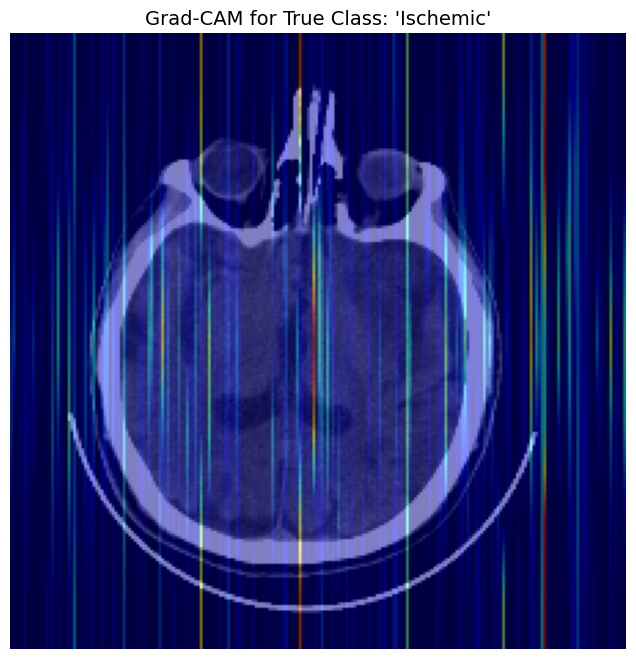

In [8]:
# First, ensure the library is installed
!pip -q install grad-cam

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# Identify the correct target layer in ConvNeXt. The final normalization layer
# or the block before it are good candidates.
target_layer = model.stages[-1].blocks[-1].norm

# Initialize GradCAM
cam = GradCAM(model=model, target_layers=[target_layer])

# Get a sample image from the test dataset that represents a stroke
stroke_indices = [i for i, label in enumerate(test_labels) if label > 0]
if not stroke_indices:
    print("No stroke cases found in the test set to visualize.")
else:
    # Get a sample image and its true label
    sample_idx = stroke_indices[0]
    input_tensor, true_label_tensor = test_dataset[sample_idx]
    true_label = true_label_tensor.item()
    
    # Denormalize for visualization
    input_img_vis = input_tensor.permute(1, 2, 0).numpy()
    input_img_vis = (input_img_vis * 0.5 + 0.5)
    
    # Add batch dimension for the model
    input_tensor = input_tensor.unsqueeze(0).to(device)

    # Define the target for CAM. We want to see why the model chose its predicted class.
    # For multi-class, we can specify the target class. Here we see why it chose the *true* class.
    targets = [ClassifierOutputTarget(true_label)]

    # Generate the CAM
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0, :]

    # Overlay the CAM on the image
    visualization = show_cam_on_image(input_img_vis, grayscale_cam, use_rgb=True)

    # Display the result
    plt.figure(figsize=(8, 8))
    plt.imshow(visualization)
    plt.title(f"Grad-CAM for True Class: '{class_names[true_label]}'", fontsize=14)
    plt.axis('off')
    plt.show()

# Error Analysis: Misclassified Images

Found 20 misclassified images out of 671.
Displaying some misclassified images...


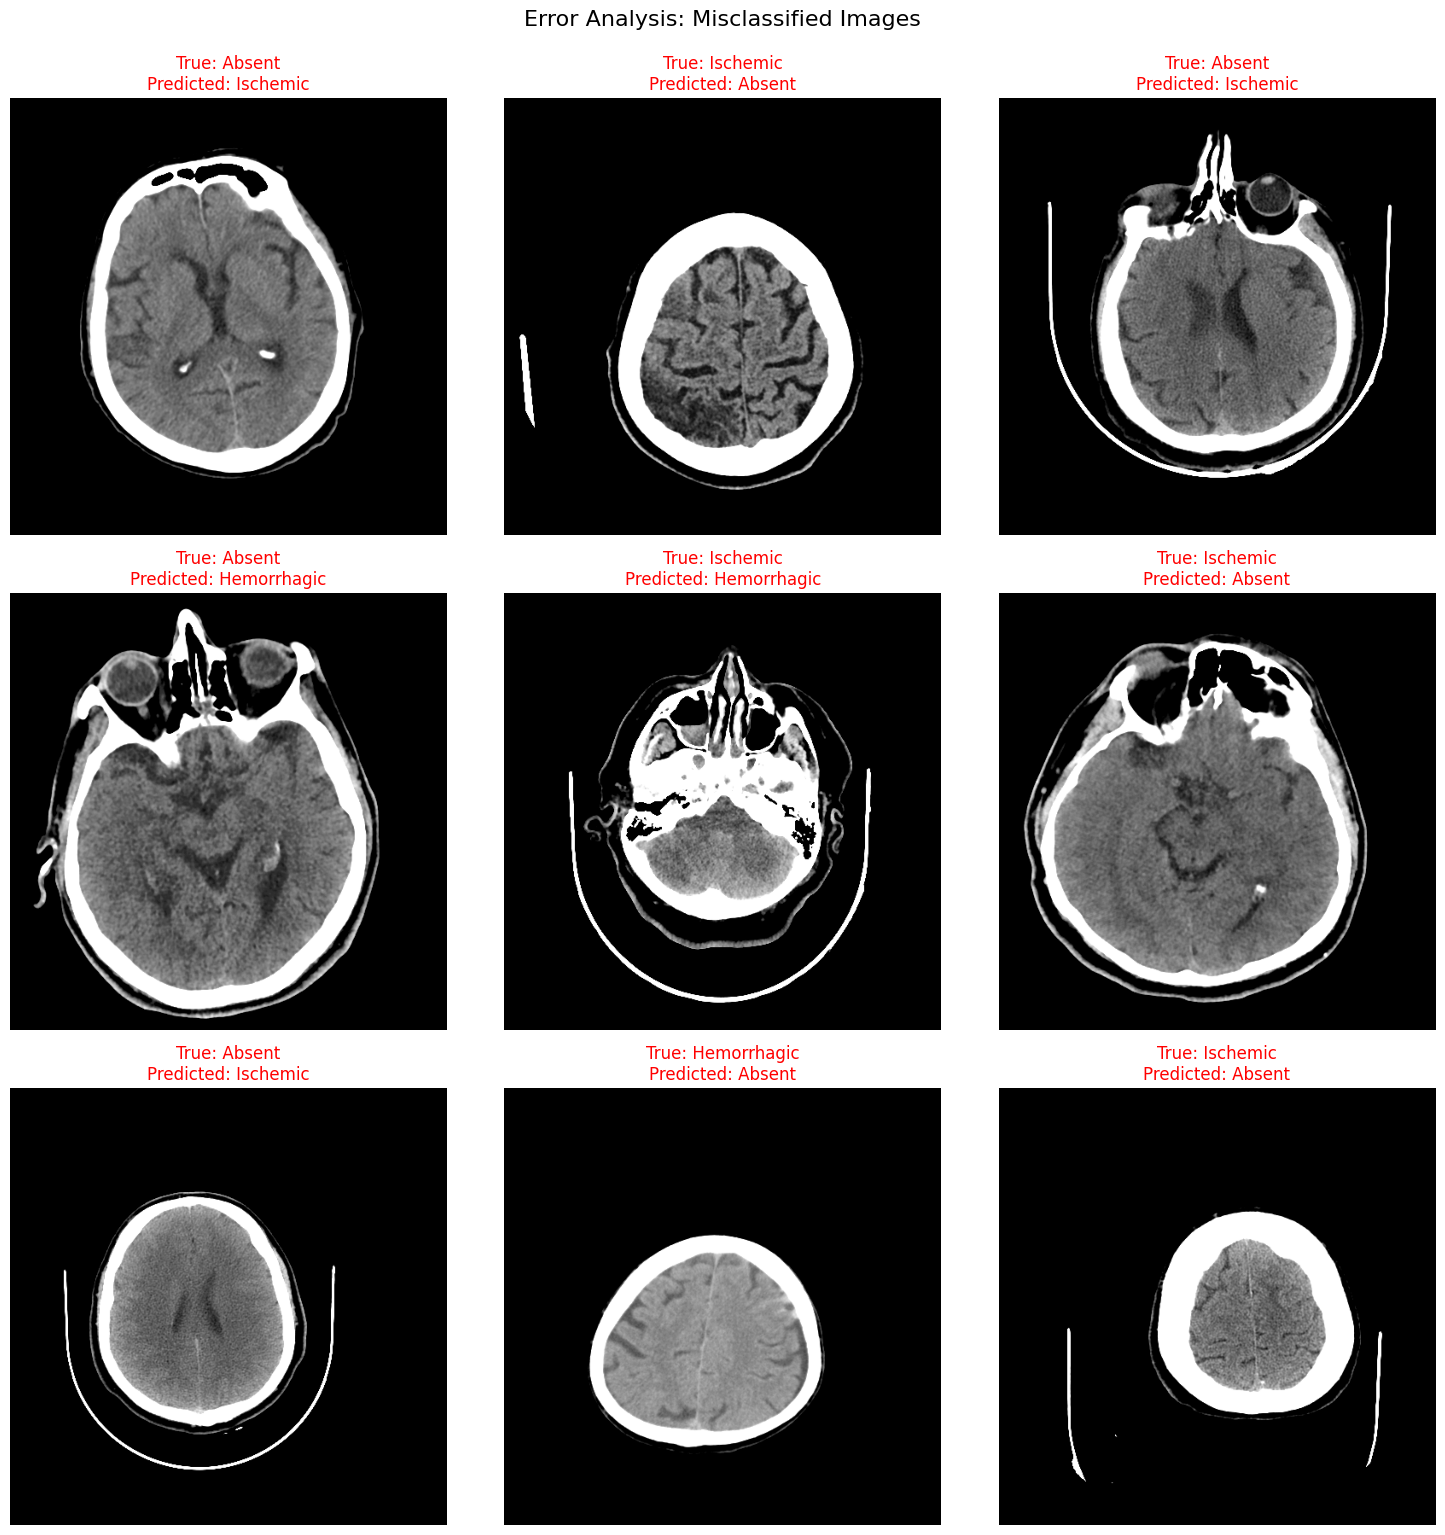

In [10]:
import math
import pandas as pd
# Create a DataFrame with test results for analysis
results_df = pd.DataFrame({
    "Image_Path": test_paths,
    "True_Label": test_labels_arr,
    "Predicted_Label": test_preds,
})

# Find incorrect predictions
misclassified_df = results_df[results_df['True_Label'] != results_df['Predicted_Label']]
print(f"Found {len(misclassified_df)} misclassified images out of {len(results_df)}.")

if not misclassified_df.empty:
    print("Displaying some misclassified images...")
    
    # Define class names for plotting
    class_names = {0: "Absent", 1: "Ischemic", 2: "Hemorrhagic"}
    
    # Number of images to display
    num_to_show = min(len(misclassified_df), 9)
    num_cols = 3
    num_rows = math.ceil(num_to_show / num_cols)

    plt.figure(figsize=(15, 5 * num_rows))
    for i, (index, row) in enumerate(misclassified_df.head(num_to_show).iterrows()):
        plt.subplot(num_rows, num_cols, i + 1)
        img = cv2.imread(row['Image_Path'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        true_label_name = class_names[row['True_Label']]
        pred_label_name = class_names[row['Predicted_Label']]
        
        plt.imshow(img)
        plt.title(f"True: {true_label_name}\nPredicted: {pred_label_name}", fontsize=12, color='red')
        plt.axis('off')
    
    plt.tight_layout()
    plt.suptitle("Error Analysis: Misclassified Images", fontsize=16, y=1.02)
    plt.show()

# Multi-Class Receiver Operating Characteristic (ROC)

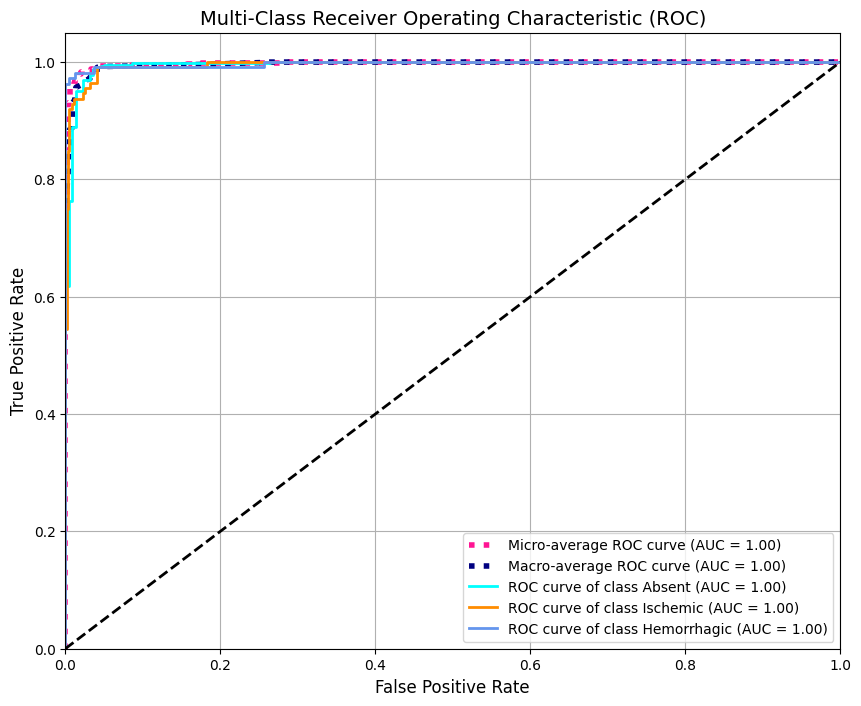

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
# The incorrect 'from scipy import interp' is now removed. We will use np.interp.

# --- Step 1: Get True Labels and Predicted Probabilities ---

# Load the best model for evaluation
model.load_state_dict(torch.load("best_model_multiclass.pth"))
model.eval()

y_true = []
y_score = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Get raw model outputs
        outputs = model(images)
        # Apply softmax to get probabilities
        probs = torch.softmax(outputs, dim=1)
        
        y_score.extend(probs.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

y_true = np.array(y_true)
y_score = np.array(y_score)
# Define class names if not already available
class_names = ["Absent", "Ischemic", "Hemorrhagic"]
n_classes = len(class_names)

# Binarize the true labels for the One-vs-Rest (OvR) strategy
y_true_binarized = label_binarize(y_true, classes=range(n_classes))


# --- Step 2: Calculate ROC Curve and AUC for each class (OvR) ---

# Dictionaries to store ROC curve data
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# --- Step 3: Calculate Micro-Average ROC Curve ---

# Aggregate all true labels and scores
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_binarized.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


# --- Step 4: Calculate Macro-Average ROC Curve ---

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    # Use numpy.interp instead of the old scipy.interp
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])


# --- Step 5: Plot all ROC Curves ---

plt.figure(figsize=(10, 8))

# Plot Micro-average ROC
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC curve (AUC = {roc_auc["micro"]:0.2f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot Macro-average ROC
plt.plot(fpr["macro"], tpr["macro"],
         label=f'Macro-average ROC curve (AUC = {roc_auc["macro"]:0.2f})',
         color='navy', linestyle=':', linewidth=4)

# Plot ROC for each class
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {class_names[i]} (AUC = {roc_auc[i]:0.2f})')

# Plot the no-skill line
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Multi-Class Receiver Operating Characteristic (ROC)', fontsize=14)
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [ ]:
# CELL 1: THE INSTALLER AND KERNEL RESTARTER

print("STEP 1: Forcing re-installation of specific, compatible libraries.")
print("This will fix the version conflict between scikit-learn and umap-learn.")

# We are pinning specific versions that are known to work together.
!pip -q install -U scikit-learn==1.2.2 umap-learn==0.5.3 numba==0.56.4 -q

import os

print("\nSTEP 2: Libraries updated. The kernel will now restart automatically.")
print("This is a necessary step to load the correct library versions.")
print("Do NOT run this cell again. Run the next cell (the UMAP code) after this one finishes.")

# This command will crash and restart the Python kernel to clear the old libraries.
os._exit(0)

STEP 1: Forcing re-installation of specific, compatible libraries.
This will fix the version conflict between scikit-learn and umap-learn.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 75.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 78.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.6/34.6 MB 53.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 79.8 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albucore 0.0.19 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
albumentations 1.4.20 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
bayesian-optimization 2.0.3 re

Re-importing libraries...


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Re-initializing data loaders...
Creating model with the correct 3-class architecture...


<ipython-input-1-3ee86a121f02>:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model_multiclass.pth"))


Creating feature extractor...
Extracting features from all test images...
Running UMAP for 2D projection...


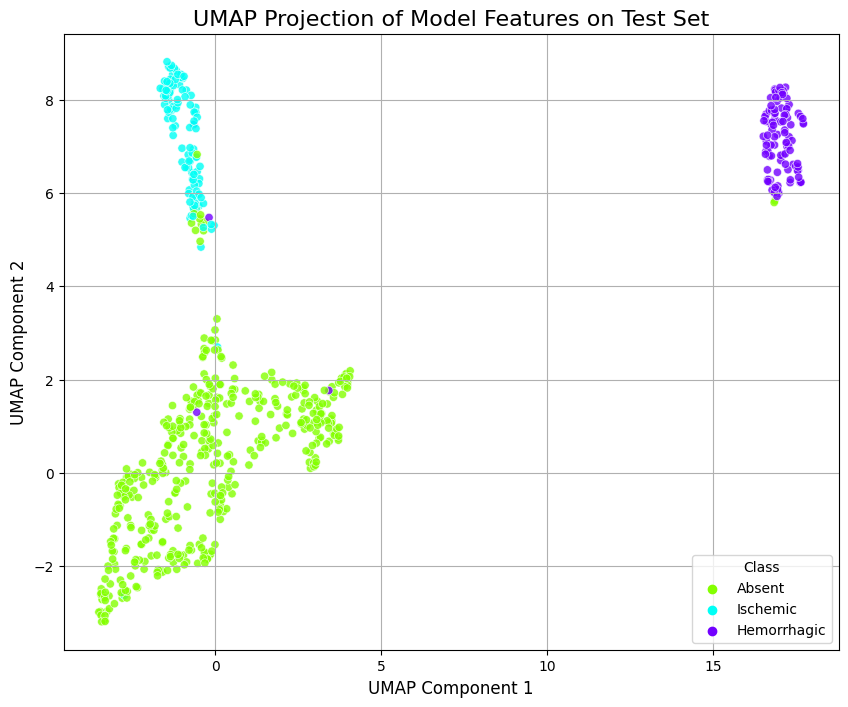

In [1]:
# CELL 2: THE VISUALIZATION CODE (Run this AFTER the kernel restarts)

# --- Step 1: Re-import all necessary libraries ---
print("Re-importing libraries...")
import torch
import timm
import umap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from glob import glob
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2

# --- Step 2: Re-initialize key variables and data loaders ---
print("Re-initializing data loaders...")
seed = 42
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_names = {0: "Absent", 1: "Ischemic", 2: "Hemorrhagic"}
n_classes = len(class_names)

# Define paths and labels again
BASE_DIR = '/kaggle/input/inme-veri-seti-stroke-dataset/İNME VERİ SETİ'
stroke_absent_dir = os.path.join(BASE_DIR, "İnme Yok")
stroke_iskemi_dir = os.path.join(BASE_DIR, "İskemi", "PNG")
stroke_kanama_dir = os.path.join(BASE_DIR, "Kanama", "PNG")
absent_paths = glob(os.path.join(stroke_absent_dir, "*"))
iskemi_paths = glob(os.path.join(stroke_iskemi_dir, "*"))
kanama_paths = glob(os.path.join(stroke_kanama_dir, "*"))
image_paths = absent_paths + iskemi_paths + kanama_paths
labels = [0] * len(absent_paths) + [1] * len(iskemi_paths) + [2] * len(kanama_paths)

# Re-run the train-test split to get the same test set (due to fixed seed)
_, temp_paths, _, temp_labels = train_test_split(image_paths, labels, test_size=0.3, random_state=seed, stratify=labels)
_, test_paths, _, test_labels = train_test_split(temp_paths, temp_labels, test_size=0.33, random_state=seed, stratify=temp_labels)

# Re-define the Dataset class
class StrokeDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        if self.transform:
            image = self.transform(image=image)['image']
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return image, label

val_transform = A.Compose([A.Resize(224, 224), A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)), ToTensorV2()])
test_dataset = StrokeDataset(test_paths, test_labels, transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

# --- Step 3: Create Model with Correct Architecture BEFORE Loading ---
print("Creating model with the correct 3-class architecture...")

# THE FIX IS HERE: Create the model with the correct number of classes from the start.
model = timm.create_model('convnext_base', pretrained=True, num_classes=n_classes)
model.to(device)

# Now, loading the state dict will work because the architectures match.
model.load_state_dict(torch.load("best_model_multiclass.pth"))

# --- Step 4: Create Feature Extractor ---
print("Creating feature extractor...")
model.reset_classifier(0) # Remove final layer to get features
model.eval()

# --- Step 5: Extract Features ---
print("Extracting features from all test images...")
all_features = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        features = model(images)
        all_features.append(features.cpu().numpy())
        all_labels.append(labels.cpu().numpy())
all_features = np.concatenate(all_features)
all_labels = np.concatenate(all_labels)

# --- Step 6: Run UMAP and Plot ---
print("Running UMAP for 2D projection...")
reducer = umap.UMAP(n_components=2, random_state=seed)
embedding = reducer.fit_transform(all_features)
df = pd.DataFrame(embedding, columns=['UMAP_1', 'UMAP_2'])
df['True_Label'] = all_labels
df['Class'] = df['True_Label'].map(class_names)

plt.figure(figsize=(10, 8))
sns.scatterplot(x="UMAP_1", y="UMAP_2", hue="Class", palette=sns.color_palette("hsv", n_colors=3), data=df, legend="full", alpha=0.8)
plt.title('UMAP Projection of Model Features on Test Set', fontsize=16)
plt.xlabel('UMAP Component 1', fontsize=12)
plt.ylabel('UMAP Component 2', fontsize=12)
plt.grid(True)
plt.show()

# Restore the model's classifier head for any subsequent cells
model.reset_classifier(n_classes)

# Comparative Grad-CAM (Diagnosing Errors)

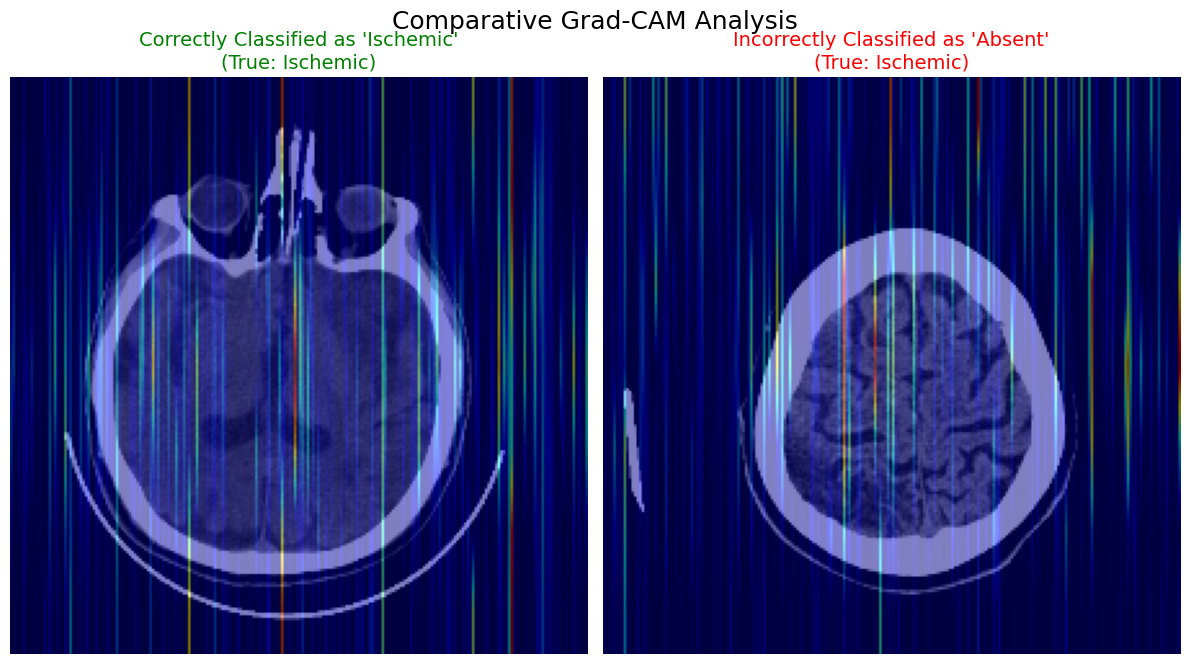

In [20]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# --- Step 1: Find a Correct and an Incorrect Example ---
# We need the results from a previous evaluation run
if 'results_df' not in locals():
    # Recalculate if not available
    model.load_state_dict(torch.load("best_model_multiclass.pth"))
    _, _, _, _, _, test_preds, test_labels_arr = evaluate(model, test_loader, criterion, device)
    results_df = pd.DataFrame({
        "Image_Path": test_paths,
        "True_Label": test_labels_arr,
        "Predicted_Label": test_preds,
    })

# Let's focus on Ischemic stroke for this example
CLASS_TO_ANALYZE = 1 # 1 for Ischemic
CLASS_NAME = "Ischemic"

correct_df = results_df[(results_df['True_Label'] == CLASS_TO_ANALYZE) & (results_df['Predicted_Label'] == CLASS_TO_ANALYZE)]
incorrect_df = results_df[(results_df['True_Label'] == CLASS_TO_ANALYZE) & (results_df['Predicted_Label'] != CLASS_TO_ANALYZE)]

if correct_df.empty or incorrect_df.empty:
    print(f"Could not find both a correct and incorrect example for class '{CLASS_NAME}'. Skipping visualization.")
else:
    # --- Step 2: Setup Grad-CAM ---
    target_layer = model.stages[-1].blocks[-1].norm
    cam = GradCAM(model=model, target_layers=[target_layer])
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 7))
    
    # --- Process Correct Image ---
    correct_idx = correct_df.index[0]
    correct_img_path = results_df.loc[correct_idx, 'Image_Path']
    input_tensor, _ = test_dataset[test_paths.index(correct_img_path)] # Get tensor from original dataset
    targets = [ClassifierOutputTarget(CLASS_TO_ANALYZE)]
    grayscale_cam = cam(input_tensor=input_tensor.unsqueeze(0).to(device), targets=targets)[0, :]
    vis = show_cam_on_image((input_tensor.permute(1,2,0).numpy() * 0.5 + 0.5), grayscale_cam, use_rgb=True)
    axs[0].imshow(vis)
    axs[0].set_title(f"Correctly Classified as '{CLASS_NAME}'\n(True: {CLASS_NAME})", color='green', fontsize=14)
    axs[0].axis('off')

    # --- Process Incorrect Image ---
    incorrect_idx = incorrect_df.index[0]
    incorrect_img_path = results_df.loc[incorrect_idx, 'Image_Path']
    predicted_label = results_df.loc[incorrect_idx, 'Predicted_Label']
    predicted_name = class_names[predicted_label]
    input_tensor, _ = test_dataset[test_paths.index(incorrect_img_path)]
    # Target the *incorrectly predicted* class to see why the model made the mistake
    targets = [ClassifierOutputTarget(predicted_label)]
    grayscale_cam = cam(input_tensor=input_tensor.unsqueeze(0).to(device), targets=targets)[0, :]
    vis = show_cam_on_image((input_tensor.permute(1,2,0).numpy() * 0.5 + 0.5), grayscale_cam, use_rgb=True)
    axs[1].imshow(vis)
    axs[1].set_title(f"Incorrectly Classified as '{predicted_name}'\n(True: {CLASS_NAME})", color='red', fontsize=14)
    axs[1].axis('off')

    plt.suptitle("Comparative Grad-CAM Analysis", fontsize=18)
    plt.tight_layout()
    plt.show()

# Prediction Confidence Plots (Understanding Model Certainty)

Getting model prediction probabilities for the test set...


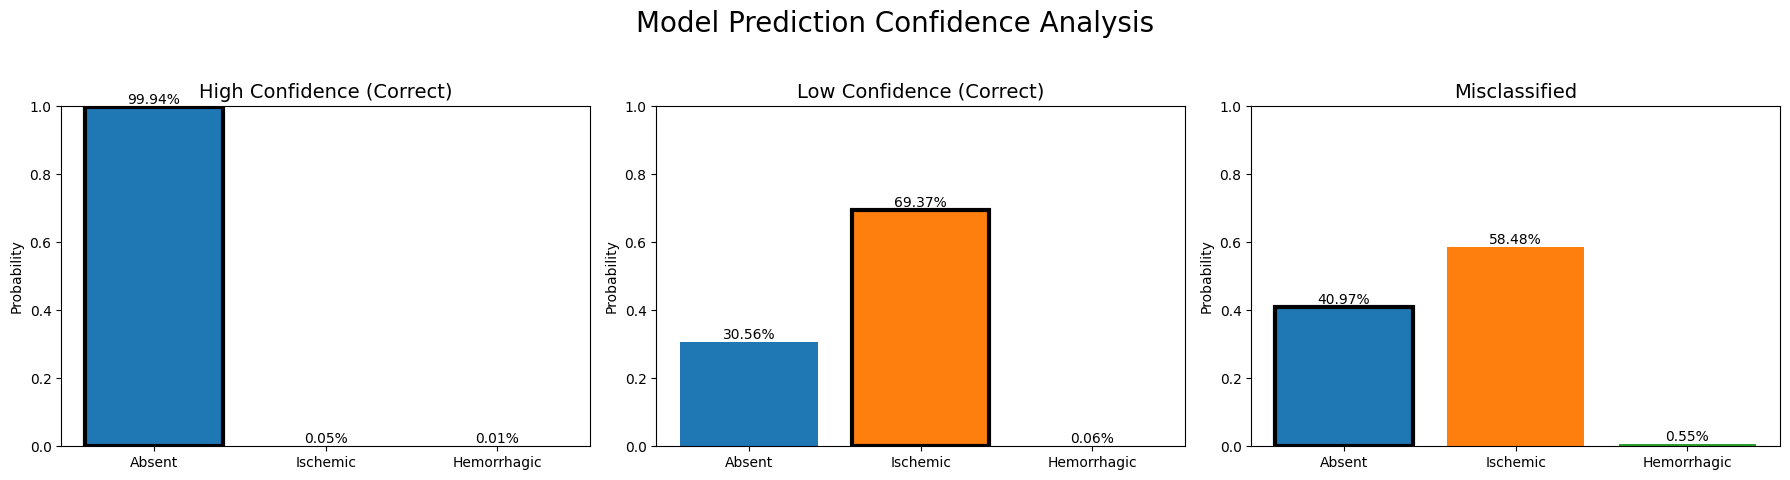

In [21]:
# --- Step 1: Get Model Probabilities for the test set ---
# This reuses the logic from the ROC curve cell
print("Getting model prediction probabilities for the test set...")
model.load_state_dict(torch.load("best_model_multiclass.pth"))
model.eval()
y_score = []
with torch.no_grad():
    for images, _ in test_loader:
        outputs = model(images.to(device))
        probs = torch.softmax(outputs, dim=1)
        y_score.extend(probs.cpu().numpy())
y_score = np.array(y_score)

# Add probabilities to our results DataFrame
prob_df = pd.DataFrame(y_score, columns=[f"Prob_{name}" for name in class_names])
results_with_probs = pd.concat([results_df.reset_index(drop=True), prob_df], axis=1)
results_with_probs['Max_Prob'] = results_with_probs[[f"Prob_{name}" for name in class_names]].max(axis=1)


# --- Step 2: Find Interesting Cases ---
# Case 1: High-confidence correct prediction
high_conf_correct = results_with_probs[
    (results_with_probs['True_Label'] == results_with_probs['Predicted_Label']) &
    (results_with_probs['Max_Prob'] > 0.95)
].head(1)

# Case 2: Low-confidence correct prediction
low_conf_correct = results_with_probs[
    (results_with_probs['True_Label'] == results_with_probs['Predicted_Label']) &
    (results_with_probs['Max_Prob'] < 0.7)
].head(1)

# Case 3: A misclassification
misclassified = results_with_probs[
    results_with_probs['True_Label'] != results_with_probs['Predicted_Label']
].head(1)

cases = {
    "High Confidence (Correct)": high_conf_correct,
    "Low Confidence (Correct)": low_conf_correct,
    "Misclassified": misclassified
}

# --- Step 3: Plot the Confidence Bars ---
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle("Model Prediction Confidence Analysis", fontsize=20)

for i, (title, case_df) in enumerate(cases.items()):
    ax = axs[i]
    if case_df.empty:
        ax.text(0.5, 0.5, f"No case found for\n'{title}'", ha='center', va='center', fontsize=12)
        ax.set_title(title, fontsize=14)
        ax.axis('off')
        continue
        
    case_probs = case_df[[f"Prob_{name}" for name in class_names]].iloc[0].values
    true_label_idx = case_df['True_Label'].iloc[0]
    
    bars = ax.bar(class_names, case_probs, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
    ax.set_title(title, fontsize=14)
    ax.set_ylabel("Probability")
    ax.set_ylim(0, 1)
    
    # Highlight the true label's bar
    bars[true_label_idx].set_edgecolor('black')
    bars[true_label_idx].set_linewidth(3)
    
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2%}', va='bottom', ha='center')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Recalculating final test metrics for per-class analysis...


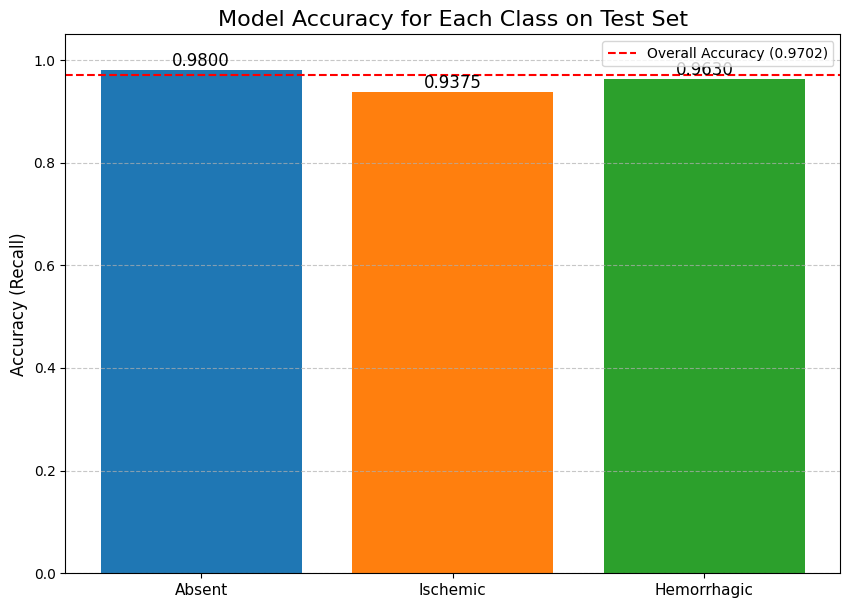


--- Per-Class Accuracy (Recall) ---
Absent: 0.9800
Ischemic: 0.9375
Hemorrhagic: 0.9630


In [18]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# --- Step 1: Ensure Final Metrics and Predictions are Calculated ---
# This ensures we have the latest results from the best model.

print("Recalculating final test metrics for per-class analysis...")
# Load the best saved model
model.load_state_dict(torch.load("best_model_multiclass.pth"))

# Evaluate on the test set to get the latest predictions and labels
test_loss, overall_accuracy, _, _, _, test_preds, test_labels_arr = evaluate(model, test_loader, criterion, device)


# --- Step 2: Calculate Per-Class Accuracy from the Confusion Matrix ---

# Generate the confusion matrix
cm = confusion_matrix(test_labels_arr, test_preds)

# Calculate per-class accuracy (recall)
# The diagonal elements are the true positives for each class.
# The sum across the rows gives the total actual instances for each class.
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)

# Define class names for plotting
class_names = ["Absent", "Ischemic", "Hemorrhagic"]


# --- Step 3: Create the Performance Bar Chart ---

plt.figure(figsize=(10, 7))
bars = plt.bar(class_names, per_class_accuracy, color=['#1f77b4', '#ff7f0e', '#2ca02c'])

# Add a horizontal line representing the overall accuracy for comparison
plt.axhline(y=overall_accuracy, color='r', linestyle='--', label=f'Overall Accuracy ({overall_accuracy:.4f})')

# Add labels and title for clarity
plt.ylabel('Accuracy (Recall)', fontsize=12)
plt.title('Model Accuracy for Each Class on Test Set', fontsize=16)
plt.ylim(0, 1.05) # Set y-axis from 0 to 105%
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add the exact value on top of each bar
for i, bar in enumerate(bars):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.4f}', va='bottom', ha='center', fontsize=12)

plt.xticks(fontsize=11)
plt.legend()
plt.show()

# Optional: Print the exact values
print("\n--- Per-Class Accuracy (Recall) ---")
for i, class_name in enumerate(class_names):
    print(f"{class_name}: {per_class_accuracy[i]:.4f}")

Recalculating final test metrics for visualization...
Final Test Accuracy: 0.9702
Final Test F1 Score (Macro): 0.9593


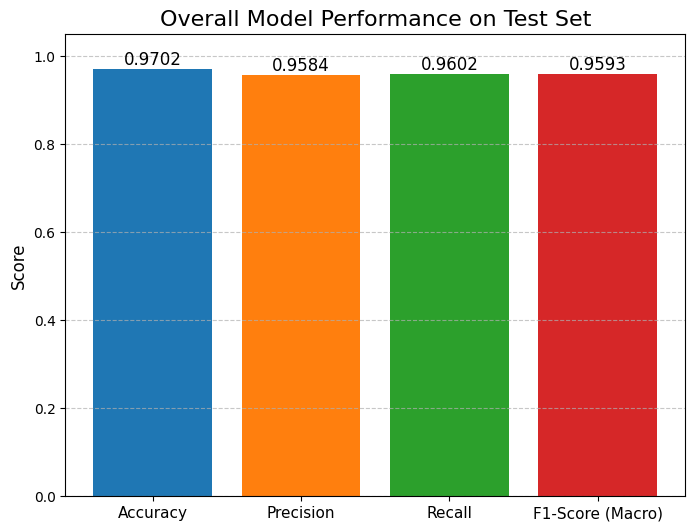

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# --- Step 1: Ensure Final Metrics are Calculated ---
# This part is repeated from the training cell to make this block self-contained.
# It ensures you are plotting the most recent results from the best model.

print("Recalculating final test metrics for visualization...")

# Load the best saved model
model.load_state_dict(torch.load("best_model_multiclass.pth"))

# Evaluate the model on the test set
test_loss, test_acc, test_prec, test_rec, test_f1, _, _ = evaluate(model, test_loader, criterion, device)

print(f"Final Test Accuracy: {test_acc:.4f}")
print(f"Final Test F1 Score (Macro): {test_f1:.4f}")


# --- Step 2: Create the Performance Bar Chart ---

# Define the metrics and their values
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score (Macro)']
metrics_values = [test_acc, test_prec, test_rec, test_f1]

# Create the plot
plt.figure(figsize=(8, 6))
bars = plt.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])

# Add labels and title for clarity
plt.ylabel('Score', fontsize=12)
plt.title('Overall Model Performance on Test Set', fontsize=16)
plt.ylim(0, 1.05) # Set y-axis from 0 to 105%
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add the exact value on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.4f}', va='bottom', ha='center', fontsize=12) # va='bottom' puts text above the bar

plt.xticks(fontsize=11)
plt.show()

In [16]:
from IPython.display import FileLink

# The name of the saved model file
model_filename = "best_model_multiclass.pth"

print(f"Click the link below to download the model file to your laptop:")

# This command creates a clickable HTML link to the file
FileLink(r'best_model_multiclass.pth')

Click the link below to download the model file to your laptop:


/kaggle/working/best_model_multiclass.pth